[Open this notebook on Colab](https://colab.research.google.com/github/probabll/ntmi-tutorials/blob/main/T2.ipynb)

# Guide

Check the guide carefully before starting.

## ILOs

After completing this lab you should be able to

* implement a Naive Bayes text classifier in Python, this includes parameter estimation and assessment of joint, conditional and marginal probabilities
* analyse space and time complexity of NBC (model and essential computations)
* predict and evaluate models using precision/recall

**General notes**

* In this notebook you are expected to use $\LaTeX$.
* Use python3.
* Use NLTK (3.5) to read annotated data.


## Table of contents




### Topics

* [Labelled data](#sec:Labelled_data)
* [Generative text classification](#sec:Generative_text_classification)
* [Implementation](#sec:Implementation)
* [Experiment](#sec:Experiment)
* [Error analysis](#sec:Error_analysis)


### Table of ungraded exercises

1. [Visualise data](#ungraded-1)
1. [Categorical parameters](#ungraded-2)
1. [Log prior](#ungraded-3)
1. [Log conditional](#ungraded-4)
1. [Log joint](#ungraded-5)
1. [Log marginal](#ungraded-6)
1. [Log posterior](#ungraded-7)
1. [Most probable class](#ungraded-8)
1. [Estimate class probabilities (prior parameters)](#ungraded-9)
1. [Estimate class-conditioned word probabilities (conditional parameters)](#ungraded-10)


### Table of graded exercises

*Important:* The grader may re-run your notebook to investigate its correctness, but you must upload your notebook with the cells already run and make sure that all your answers are visible without the need to re-run the notebook.


Exercises have equal weights.


1. [NBC for sentence polarity](#graded-1)
1. [Grid Search](#graded-2)
1. [Error analysis](#graded-3)


## How to use this notebook

* Check the entire notebook before you get started, this gives you an idea of what lies ahead.
* Note that, as always, the notebook recaps theory, and contains solved quizzes. While you should probably make use of this theory recap, be careful not to spend disproportionately more time on this than you should. The theory here is very condensed, and to understand it you need to complete HC2a and the reading listed as preparation to this session.
* The last section is optional for this tutorial, but note that it helps connect T1 and T2. So, you might want to work on it once you are done with the graded exercises.


<a name='sec:Labelled_data'></a>
# Labelled data

In this tutorial we will be looking into text classification with labelled data (that is, text that has been categorised or somehow labelled for certain attributes).
    
This can be binary classification, for example,

* `nltk.corpus.sentence_polarity`
* `nltk.corpus.movie_reviews`
* `nltk.corpus.subjectivity`    
    
One multiclass classification, for example,
* `nltk.corpus.brown`    

In [ ]:
# You might need to install these:


# !pip install pandas
# !pip install seaborn
# !pip install nltk
# !pip install tabulate
# !pip install sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [12]:
nltk.download('punkt')
nltk.download('sentence_polarity')
nltk.download('movie_reviews')
nltk.download('subjectivity')
nltk.download('brown')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package sentence_polarity to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package sentence_polarity is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

It's always good to visualise some properties of the data we will be manipulating. Basic properties of interest are the frequency of the classes, the lenght of the documents in it.

Visualising the frequency of classes can warn you that your dataset is unballanced, length of documents can warn you that some datasets can be challenging for you personal computer.

We could plot these quantities any way we like, but pandas and seaborn together make it really easy to get insightful visualisations, so we will share this trick with you.

In [3]:
def get_corpus_df(corpus, categories=None):
    """
    Return a tall dataframe for a nltk text classification corpus.
    corpus: an instance of nltk.corpus meant for text classification
    categories: None or a list of categories (in case we want to use just a portion of the labelled documents)
    """
    if categories is None:
        categories = corpus.categories()
    rows = []
    for label in categories:
        rows.extend((label, len(x)) for x in corpus.sents(categories=[label]))
    return pd.DataFrame(rows, columns=['label', 'length'])

**Subjectivity**

In [4]:
from nltk.corpus import subjectivity

subjectivity_df = get_corpus_df(subjectivity)

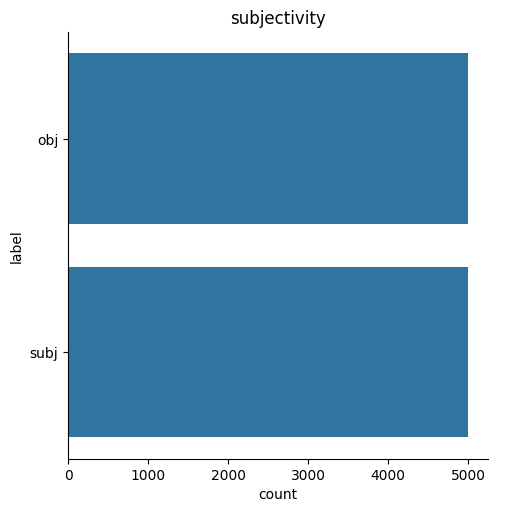

In [5]:
_ = sns.catplot(y='label', orient='h', kind='count', data=subjectivity_df).set(title="subjectivity")

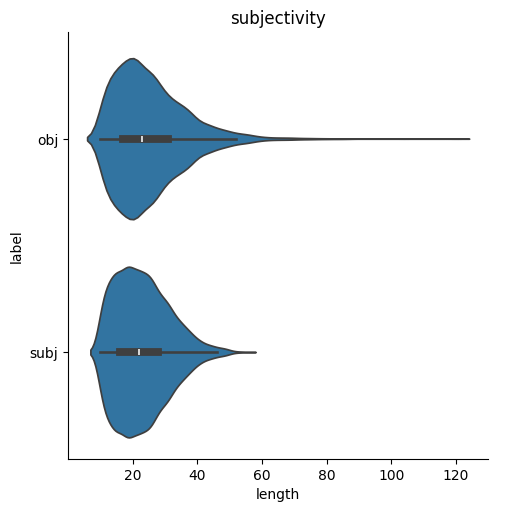

In [6]:
_ = sns.catplot(x='length', y='label', kind='violin', data=subjectivity_df).set(title="subjectivity")

Two types of documents (objective and subjective) that are equally represented, and they are reasonably short documents (mostly 10-40 tokens). The distribution of document length is mostly similar for both classes, but the objective class shows a longer tail.

It is also a good idea to inspect actual documents in each class. Familiarity with our datasets makes us better researchers.

In [7]:
for x, y in zip(subjectivity.sents(categories=['obj']), ['obj'] * 10):
    print(y, ' '.join(x))

obj the movie begins in the past where a young boy named sam attempts to save celebi from a hunter .
obj emerging from the human psyche and showing characteristics of abstract expressionism , minimalism and russian constructivism , graffiti removal has secured its place in the history of modern art while being created by artists who are unconscious of their artistic achievements .
obj spurning her mother's insistence that she get on with her life , mary is thrown out of the house , rejected by joe , and expelled from school as she grows larger with child .
obj amitabh can't believe the board of directors and his mind is filled with revenge and what better revenge than robbing the bank himself , ironic as it may sound .
obj she , among others excentricities , talks to a small rock , gertrude , like if she was alive .
obj this gives the girls a fair chance of pulling the wool over their eyes using their sexiness to poach any last vestige of common sense the dons might have had .
obj styl

In [8]:
for x, y in zip(subjectivity.sents(categories=['subj']), ['subj'] * 10):
    print(y, ' '.join(x))

subj smart and alert , thirteen conversations about one thing is a small gem .
subj color , musical bounce and warm seas lapping on island shores . and just enough science to send you home thinking .
subj it is not a mass-market entertainment but an uncompromising attempt by one artist to think about another .
subj a light-hearted french film about the spiritual quest of a fashion model seeking peace of mind while in a love affair with a veterinarian who is a non-practicing jew .
subj my wife is an actress has its moments in looking at the comic effects of jealousy . in the end , though , it is only mildly amusing when it could have been so much more .
subj works both as an engaging drama and an incisive look at the difficulties facing native americans .
subj even a hardened voyeur would require the patience of job to get through this interminable , shapeless documentary about the swinging subculture .
subj when perry fists a bull at the moore farm , it's only a matter of time before h

<a name='ungraded-1'></a> **Ungraded Exercise 1 - Visualise data**

Use the same 3 visualisation/inspections techniques as well as 1 more (which you can choose) on the following three corpora:

* `nlt.corpus.sentence_polarity`
* `nltk.corpus.movie_reviews`
* `nltk.corpus.brown`

and like we did, make some remarks about what you see. For `brown` which has many classes, you can inspect fewer documents per class, or pick 3-4 of the classes and inspect documents for those only.


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

from nltk.corpus import sentence_polarity

# class frequency
# length histogram

sentence_polarity_df = get_corpus_df(sentence_polarity)
_ = sns.catplot(y='label', orient='h', kind='count', data=sentence_polarity_df).set(title="sentence_polarity")
_ = sns.catplot(x='length', y='label', kind='violin', data=sentence_polarity_df).set(title="sentence_polarity")
from nltk.corpus import movie_reviews
movie_reviews_df = get_corpus_df(movie_reviews)
_ = sns.catplot(y='label', orient='h', kind='count', data=movie_reviews_df).set(title="movie_reviews")
_ = sns.catplot(x='length', y='label', kind='violin', data=movie_reviews_df).set(title="movie_reviews")
from nltk.corpus import brown
brown_df = get_corpus_df(brown)
_ = sns.catplot(y='label', orient='h', kind='count', data=brown_df).set(title="brown")
_ = sns.catplot(x='length', y='label', kind='violin', data=brown_df).set(title="brown")


# Also list some examples

# Additional (examples):
# * List the most frequent words
# * Plot word vs freq
# * Plot rank vs freq

# from itertools import compress

# # for y in brown.categories():
# #     print("Label: '{}'".format(y))
# #     for x in compress(brown.sents(categories=[y]), [True] * 2):
# #         print(' '.join(x))

```

---
    
</details>      


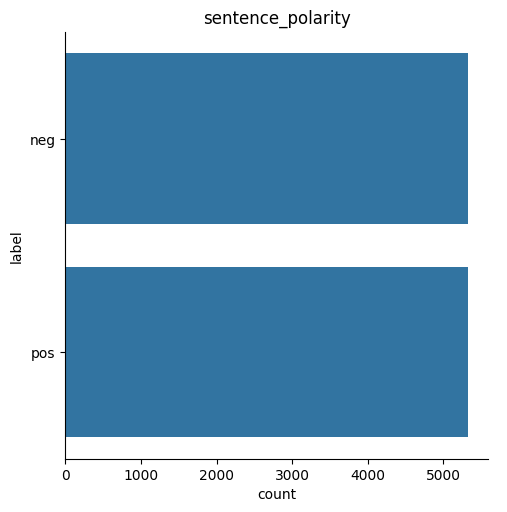

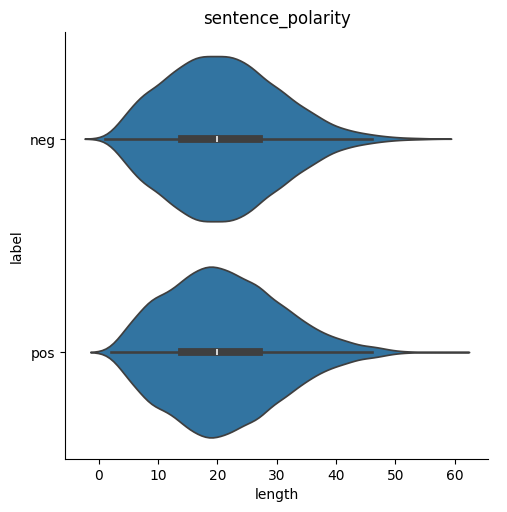

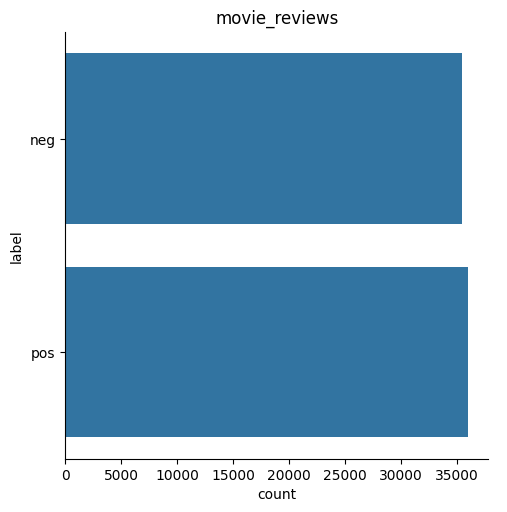

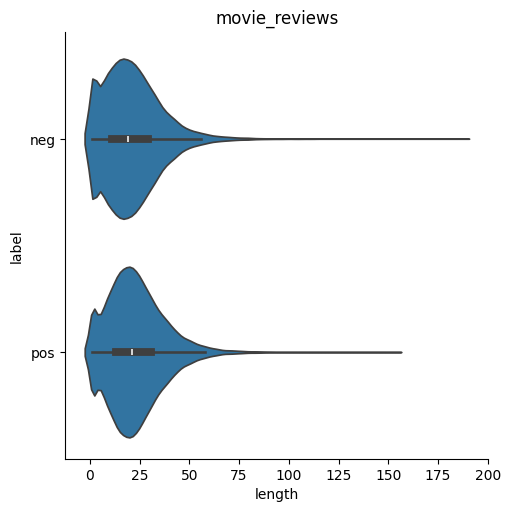

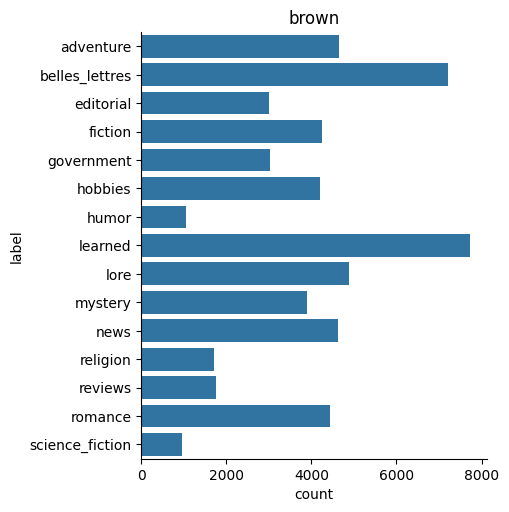

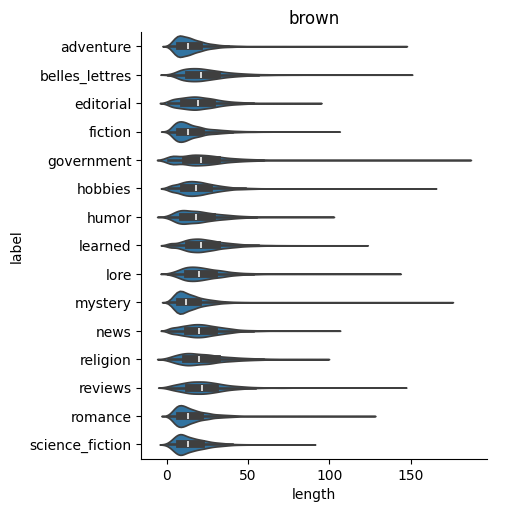

In [13]:
from nltk.corpus import sentence_polarity , movie_reviews, brown

# class frequency
# length histogram

sentence_polarity_df = get_corpus_df(sentence_polarity)
_ = sns.catplot(y='label', orient='h', kind='count', data=sentence_polarity_df).set(title="sentence_polarity")
_ = sns.catplot(x='length', y='label', kind='violin', data=sentence_polarity_df).set(title="sentence_polarity")
from nltk.corpus import movie_reviews
movie_reviews_df = get_corpus_df(movie_reviews)
_ = sns.catplot(y='label', orient='h', kind='count', data=movie_reviews_df).set(title="movie_reviews")
_ = sns.catplot(x='length', y='label', kind='violin', data=movie_reviews_df).set(title="movie_reviews")
from nltk.corpus import brown
brown_df = get_corpus_df(brown)
_ = sns.catplot(y='label', orient='h', kind='count', data=brown_df).set(title="brown")
_ = sns.catplot(x='length', y='label', kind='violin', data=brown_df).set(title="brown")

In this tutorial, **we will focus on sentiment classification** using the `sentence_polarity` dataset.

In [14]:
from tabulate import tabulate
from collections import Counter

<a name='sec:Generative_text_classification'></a>
#  Generative text classification

In NLP we often want to design systems that can read a piece of text and categorise it as an instance of one of a finite set of classes. We call those systems *text classifiers* (or text categorisers).
    
It is seldom the case that a piece of text can be reasonably mapped to *a single category*, for various reasons that we have already discussed: language is ambiguous, we often lack context (about the situation, the writer, the reader), and many implicit attributes of text are subjective by nature (e.g., one's opinion about a product). So, in practice we face text classification as a pipeline: we combine a *statistical model* and a *decision rule*.
    
The statistical model realises the mapping from a given piece of text to a *conditional probability distribution* (cpd) over the categories available. The decision rule uses the information in this distribution to elect a single category that is shown to the user.
    
---

Consider the case of *sentiment classification* with three sentiment levels (i.e., negative, neutral, and positive).

A **probabilistic sentiment classifier** maps a document $x \in \mathcal X$ to a probability distribution over the sample space $\mathcal Y = \{-1, 0, +1\}$, where -1 stands for negative, 0 stands for neutral, and +1 stands for positive sentiment. Note that we call $x$ a document, but it could be a sentence, a paragraph, or any granularity we like. A document $x$ is a sequence of words $x=\langle w_{1}, \ldots, w_{l} \rangle$, or $w_{1:l}$ for short, where $l = |x|$ is the sequence length. Each word belongs to a vocabulary $\mathcal W$ of known words, and the vocabulary size is $V$.
The space of all possible documents $\mathcal X$ is the space of all sequences made of words from $\mathcal W$, and these sequences can be of any size, a set like that is denoted $\mathcal W^*$.

So, formally, we have a random variable $X$ taking on documents in the set $\mathcal X$, a random variable $Y$ taking on classes in the set $\mathcal Y$, and a random variable $W$ taking on words in a vocabulary $\mathcal W$. A statistical model then establishes a map from any one $x \in \mathcal X$ to the cpd $P_{Y|X=x}$.

As we said in the course, the probability of a certain sentiment $y \in \{-1, 0, 1\}$ given a piece of text $x$ is not a real attribute of $x$ in the world. Rather, is is a quantification of the uncertainty that a *model of sentiment analysis* can make given text and given all of the design assumptions we made.


So, let's **design** one such model. We will pick sentiment analysis as the example, but other text classification problems fit in the same framework as long as the target classes come from a finite set of disjoint categories (e.g., sentiments, or topics, or types of named-entities, or spam vs not spam, or product categorisation in online shops, etc). Technically such sets are called *countably finite sets*.


**Goal** We want a conditional distribution $P_{Y|X=x}$ that, given some piece of text $x$ (e.g., a sentence, a paragraph, or a document), quantifies our model's beliefs in each of the classes in the sample space $\mathcal Y$.

**Challenge** At this point in the course we only know how to model Categorical distributions using the so called *tabular representation* whereby a conditional probability distribution (cpd) $Y|X=x$ would require its own set of parameters which are unique to the outcome $x$ we condition on. As documents are really long, and there's no limit to how many different documents there can be in the world, we would have to store infinitely many distributions. Even if we choose to only store those for which we have observed some $x$ in the training data, we would face another problem, namely, we would not be able to classify novel documents (those never seen before). This is a key challenge known as *data sparsity*.

**Solution** We will model a joint distribution $P_{YX}$ over $X$ and $Y$ which we will factorise using some crucial conditinal independence assumptions, namely, we will factorise $Y$ first, as in $P_{YX}(y,x)=P_Y(y)P_{X|Y}(x|y)$, and then assume that words in $x$ are independent of one another when conditioned on the class $y$, which leads to $P_{YX}(y,x) \overset{\text{ind.}}{=} P_Y(y)\prod_{i=1}^l P_{W|Y}(w_i|y)$.

This is the *naive Bayes classifier*. It's called naive because the independence assumption is unrealistic (in reality words are not independent of one another), but they are useful to get to a feasible model. It's called Bayes because to classify a given document $x$, we need to infer the distribution $P_{Y|X=x}$ from the joint distribution, which we can do via *Bayes rule*, namely, $P_{Y|X}(y|x) = \frac{P_{YX}(y, x)}{P_X(x)}$. The numerator is the joint probability, which we just defined earlier, and the denominator is the marginal probability, which we obtain via marginalisation $P_X(x) = \sum_{k \in \mathcal Y} P_{YX}(k, x)$.

We will then use a Categorical distribution for the prior distribution $P_Y$ and a set of $K$ Categorical distributions, one cpd $P_{W|Y=y}$ per class, for the class-conditioned distributions over the vocabulary. Specifically, this is the generative story:

1. Draw a class $Y \sim \mathrm{Cat}(\boldsymbol\phi)$ with $\boldsymbol\phi \in \Delta_{K-1}$
2. Draw one word a time $W|Y=y \sim \mathrm{Cat}(\boldsymbol\pi^{(y)})$ with $\boldsymbol\pi^{(y)} \in \Delta_{V-1}$, until you generate a stop symbol (a special token in the vocabulary, used to denote the end of the document/sentence).

Parameter estimation then follows via maximum likelihood estimation (MLE) for Categorical distributions, and to avoid 0 probabilities for unseen words in the future, we use *Laplace smoothing* (or add $\alpha$ smoothing).

**Looking for a refresher?** If you are not comfortable with the Categorical distribution, make sure to check T1. This [video-tutorial](https://youtu.be/1vE8zKj0-GI) (also available on Canvas) may be useful.

<a name='sec:Implementation'></a>
# Implementation

    
We will design a python class that implements NBC. We will start with some helper code to manipulate Categorical cpds, then implement the key quantities in NBC one by one. Finally, when we have all parts together we will put them together in a python class container.
    
Most exercises have solutions and test cases. We advise you to invest some time trying to develop the solutions yourself (before checking or using our own solutions), the test cases will help you with that. In case your Python skills are not sufficient at the moment, study the solutions carefully.

In [15]:
def validate_categorical_cpd(params: dict):
    """
    Just to remind you a valid Categorical cpd is a parameterised by a vector of positive
    numbers that sum to 1.

    We normally think of the parameters as a sequence or a vector,
    but in a programming language, it can be useful to use a dict,
    with a dict the indexing does not need to be numerical (we could use the label 'name'
    or the word itself to index positions in the dictionary).

    In some cases a dict may be considered slow compared to a list or array,
    but for the scale of our experiments in the tutorial, it's fine and
    conceptually much easier.

    params: map outcome to probability mass
    """
    return all(0 <= p <= 1 for p in params.values()) and np.isclose(sum(p for p in params.values()), 1., 1e-4)

In [16]:
assert validate_categorical_cpd({'pos': 0.2, 'neg': 0.8})  # fine
assert validate_categorical_cpd({'pos': 0.3, 'neg': 0.7})  # fine
assert validate_categorical_cpd({'pos': 0.2, 'neu': 0.1, 'neg': 0.7})  # we can have more than 2, that's fine
assert validate_categorical_cpd({'pos': 0.2, 'neu': 0.0, 'neg': 0.8})  # we can have 0 probs inside
assert not validate_categorical_cpd({'pos': 0.2, 'neg': 0.7})  # not good
assert not validate_categorical_cpd({'pos': 0.2})  # not good
assert not validate_categorical_cpd({'pos': -0.2, 'neu': 0.2, 'neg': 0.8})  # we cannot have 'negative probs' inside

We will now begin implementing a little piece at a time all functionalities necessary to get NBC off the floor.

As we will be manipulating some tables, the first two functions are already implemented for you to show you how you can use python dictionaries to store tables.

<a name='ungraded-2'></a> **Ungraded Exercise 2 - Categorical parameters**

Study and understand the design of `get_prior_parameter` and `get_cond_parameter` below.

In [17]:
def get_prior_parameter(y: str, phi: dict):
    """
    Return P(Y=y) under the model Categorical(phi).

    y: the label
    phi: a dictionary that maps from the label to its probability mass
        even though mathematically we think of phi as a vector,
        in code it can be convenient to treat it like a dictionary some times,
        for example, as a dictionary we can use labels that are strings (rather than 0-based indices)

        For this implementation assume that phi has already been validated as a Categorical parameter.

    Return: Categorical(y|\phi)
    """
    # **SOLUTION**
    return phi.get(y, 0)  # if an outcome is outside the support, it gets 0 mass

In [18]:
assert get_prior_parameter('pos', {'pos': 0.2, 'neg': 0.8}) == 0.2
assert get_prior_parameter('neg', {'pos': 0.3, 'neg': 0.7}) == 0.7
assert get_prior_parameter('neu', {'pos': 0.3, 'neg': 0.7}) == 0.

In [19]:
def get_cond_parameter(y: str, w: str, pi: dict, UNK=None):
    """
    Return P(W=w|Y=y) under the model Categorical(\pi^{(y)}).

    y: the label
    w: word
    pi: a dictionary of dictionaries
        first we can index it using a label to obtain a dict as return,
        the latter dict are the parameters for a distribution over the vocabulary given the label
        and it can be indexed using a word to obtain a probability mass

        even though mathematically we think of pi as a table/matrix
        in code it can be convenient to treat it like a dictionary some times,
        for example, as a dictionary we can use labels that are strings (rather than 0-based indices)
        and words that are strings (rather than 0-based indices to a vocabulary).

        For this implementation assume that every dict inside of pi
         has already been validated as a Categorical parameter.
    UNK: reserved for future use

    Return: Categorical(w|\phi^{(y)})
    """
    # **SOLUTION**
    cpd = pi.get(y, None)
    if cpd is None:  # the label is not in the support of the model
        return 0.
    return cpd.get(w, 0.)  # if a word is outside the support, it gets 0 mass

In [20]:
# A test case for us, the cpds in it are valid as we can see
# (do not change this test case, it will be used in other cells)
test_phi_1 = {'pos': 0.6, 'neg': 0.4}
test_pi_1 = {
    'pos': {'not': 0.05, 'so': 0.1, 'good': 0.5, 'bad': 0.15, 'okay': 0.2 },
    'neg': {'not': 0.05, 'so': 0.1, 'good': 0.1, 'bad': 0.5, 'okay': 0.25 }
}
assert validate_categorical_cpd(test_phi_1)
assert all(validate_categorical_cpd(cpd) for y, cpd in test_pi_1.items())

# Fine
assert get_cond_parameter('pos', 'good', test_pi_1) == 0.5
assert get_cond_parameter('pos', 'not', test_pi_1) == 0.05
assert get_cond_parameter('pos', 'so', test_pi_1) == 0.1
assert get_cond_parameter('pos', 'bad', test_pi_1) == 0.15
assert get_cond_parameter('pos', 'okay', test_pi_1) == 0.2

# Fine
assert get_cond_parameter('neg', 'good', test_pi_1) == 0.1
assert get_cond_parameter('neg', 'not', test_pi_1) == 0.05
assert get_cond_parameter('neg', 'so', test_pi_1) == 0.1
assert get_cond_parameter('neg', 'bad', test_pi_1) == 0.5
assert get_cond_parameter('neg', 'okay', test_pi_1) == 0.25

# Not in the support
assert get_cond_parameter('neu', 'okay', test_pi_1) == 0.
assert get_cond_parameter('pos', 'strange', test_pi_1) == 0.
assert get_cond_parameter('neg', 'strange', test_pi_1) == 0.
assert get_cond_parameter('neu', 'strange', test_pi_1) == 0.

<a name='ungraded-3'></a> **Ungraded Exercise 3 - Log prior**

Implement a function to return $\log P_Y(y)$ for a label $y \in \mathcal Y$ under this model. Your function should use the functionality `get_prior_parameter` and/or `get_cond_parameter` from earlier. Assume the model parameters are already available.

Below you will find some assertions (ie, test cases) for you to verify your implementation.

See API below:

In [24]:
def log_prior_prob(y: str, phi: dict):
    return np.log(get_prior_parameter(y, phi))


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

def log_prior_prob(y: str, phi: dict):
    """Return log P(Y=y) under the model"""
    return np.log(get_prior_parameter(y, phi))    

```

---
    
</details>      


In [25]:
# Your code should pass these tests
assert log_prior_prob('pos', {'pos': 0.2, 'neg': 0.8}) == np.log(0.2)
assert log_prior_prob('neg', {'pos': 0.3, 'neg': 0.7}) == np.log(0.7)

<a name='ungraded-4'></a> **Ungraded Exercise 4 - Log conditional**

Implement a function to return $\log P_{X|Y}(x|y)$ for a label $y \in \mathcal Y$  and document $x \in \mathcal X$ under this model. Your function should use the functionality `get_prior_parameter` and/or `get_cond_parameter` from earlier. Assume the model parameters are already available.

Below you will find some assertions (ie, test cases) for you to verify your implementation.

See API below:

In [48]:
def log_conditional_prob(x: list, y: str, pi: dict):
    """Return log P(X=x|Y=y)"""
    return sum(np.log(get_cond_parameter(y=y, w=w, pi=pi)) for w in x)


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

def log_conditional_prob(x: list, y: str, pi: dict):
    """Return log P(X=x|Y=y) under the model"""
    # named arguments help us not make mistakes (for example, flipping y and w accidentaly)
    return sum(np.log(get_cond_parameter(y=y, w=w, pi=pi)) for w in x)      

```

---
    
</details>      


In [49]:
# Your code should pass these tests

# Fine
assert np.isclose(log_conditional_prob("not bad".split(), 'pos', test_pi_1), np.log(0.05 * 0.15), 1e-3)
assert np.isclose(log_conditional_prob("not good".split(), 'pos', test_pi_1), np.log(0.05 * 0.5), 1e-3)
assert np.isclose(log_conditional_prob("good".split(), 'pos', test_pi_1), np.log(0.5), 1e-3)

assert np.isclose(log_conditional_prob("not bad".split(), 'neg', test_pi_1), np.log(0.05 * 0.5), 1e-3)
assert np.isclose(log_conditional_prob("not good".split(), 'neg', test_pi_1), np.log(0.05 * 0.1), 1e-3)
assert np.isclose(log_conditional_prob("good".split(), 'neg', test_pi_1), np.log(0.1), 1e-3)

A good code should also deal with cases that *are not* in the support of the joint distribution. Those should have 0 probability for now (later we discuss a technique to avoid 0 probs). The log of 0 is -inf.

In [50]:
# Not in the support (should produce warnings, but pass the test)
assert log_prior_prob('neu', {'pos': 0.3, 'neg': 0.7}) == -np.inf
assert log_conditional_prob("not that bad".split(), 'pos', test_pi_1) == -np.inf
assert log_conditional_prob("not that bad".split(), 'neg', test_pi_1) == -np.inf
assert log_conditional_prob("not okay".split(), 'neu', test_pi_1) == -np.inf

# you will probably get some RuntimeWarning, this is okay here

<ipython-input-24-e9e85abd775e>:2: RuntimeWarning: divide by zero encountered in log
  return np.log(get_prior_parameter(y, phi))
<ipython-input-48-7b69baccc195>:3: RuntimeWarning: divide by zero encountered in log
  return sum(np.log(get_cond_parameter(y=y, w=w, pi=pi)) for w in x)


<a name='ungraded-5'></a> **Ungraded Exercise 5 - Log joint**

Implement a function to return $\log P_{YX}(y, x)$ for a label $y \in \mathcal Y$  and document $x \in \mathcal X$ under this model. Your function should use the functionality `log_prior_prob` and/or `log_conditional_prob` from earlier. Assume the model parameters are already available.

Below you will find some assertions (ie, test cases) for you to verify your implementation.

See API below:

In [51]:
def log_joint_prob(y: str, x: list, phi: dict, pi: dict):
    """Return log P(Y=y, X=x) under the model"""
    return log_conditional_prob(x, y, pi) + log_conditional_prob(x, y, phi)


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

def log_joint_prob(y: str, x: list, phi: dict, pi: dict):
    """Return log P(Y=y, X=x) under the model"""    
    # named arguments help us not make mistakes (eg, flipping x and y in the conditional)
    return log_prior_prob(y, phi) + log_conditional_prob(x=x, y=y, pi=pi)

```

---
    
</details>      


In [52]:
# Your code should pass these tests

assert np.isclose(
    log_joint_prob(y='pos', x="not bad".split(), phi=test_phi_1, pi=test_pi_1),
    np.log(0.6 * 0.05 * 0.15),
    1e-3
)
assert np.isclose(
    log_joint_prob(y='pos', x="not good".split(), phi=test_phi_1, pi=test_pi_1),
    np.log(0.6 * 0.05 * 0.5),
    1e-3
)


assert np.isclose(
    log_joint_prob(y='neg', x="not bad".split(), phi=test_phi_1, pi=test_pi_1),
    np.log(0.4 * 0.05 * 0.5),
    1e-3
)
assert np.isclose(
    log_joint_prob(y='neg', x="not good".split(), phi=test_phi_1, pi=test_pi_1),
    np.log(0.4 * 0.05 * 0.1),
    1e-3
)

# NBC is not sensitive to the order of words within the sentence

assert np.isclose(
    log_joint_prob(y='pos', x="bad not".split(), phi=test_phi_1, pi=test_pi_1),
    np.log(0.6 * 0.05 * 0.15),
    1e-3
)

assert np.isclose(
    log_joint_prob(y='neg', x="good not".split(), phi=test_phi_1, pi=test_pi_1),
    np.log(0.4 * 0.05 * 0.1),
    1e-3
)

AttributeError: 'float' object has no attribute 'get'

<a name='ungraded-6'></a> **Ungraded Exercise 6 - Log marginal**

Implement a function to return $\log P_{X}(x)$ for a document $x \in \mathcal X$ under this model. Your function should use the functionality `log_prior_prob` and/or `log_conditional_prob` and/or `log_joint_prob` from earlier. Assume the model parameters are already available.

Below you will find some assertions (ie, test cases) for you to verify your implementation.

See API below:

In [ ]:
def log_marginal_prob(x: list, phi: dict, pi: dict):
    """Return log P(X=x) under the model"""
    raise NotImplemented("Implement me!")


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

# **SOLUTION**
def log_marginal_prob(x: list, phi: dict, pi: dict):
    """Return log P(X=x) under the model"""    
    # Tips:
    # * compute the joint probability for x and each of the possible labels
    #   marginalise (sum)
    #   compute log
    # * or, compute all of it in log space using log_joint_prob
    #   and np.logaddexp.reduce
    
    # for the marginalisation, we need the support of the rv Y,
    # we can find it within the dictionary phi (ie, the set of keys in it)
    support_Y = phi.keys()
    # the function logaddexp(a, b) returns log(exp(a) + exp(b))
    # the method reduce applies that in a row to a whole list of values

    return np.logaddexp.reduce([log_joint_prob(y=y, x=x, phi=phi, pi=pi) for y in support_Y])

```

---
    
</details>      


In [ ]:
# Your code should pass these tests

assert np.isclose(
    log_marginal_prob(x="not bad".split(), phi=test_phi_1, pi=test_pi_1),
    np.log(0.6 * 0.05 * 0.15 + 0.4 * 0.05 * 0.5),
    1e-3
)
assert np.isclose(
    log_marginal_prob(x="not good".split(), phi=test_phi_1, pi=test_pi_1),
    np.log(0.6 * 0.05 * 0.5 + 0.4 * 0.05 * 0.1),
    1e-3
)

<a name='ungraded-7'></a> **Ungraded Exercise 7 - Log posterior**

Implement a function to return $\log P_{Y|X}(y|x)$ for a label $y\in \mathcal Y$ and document $x \in \mathcal X$ under this model. Your function should use the functionality `log_prior_prob` and/or `log_conditional_prob` and/or `log_joint_prob` and/or `log_marginal_prob` from earlier. Assume the model parameters are already available.

Below you will find some assertions (ie, test cases) for you to verify your implementation.

See API below:

In [ ]:
def log_posterior_prob(y: str, x: list, phi: dict, pi: dict):
    """Return log P(Y=y|X=x) under the model"""
    raise NotImplemented("Implement me !")


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

def log_posterior_prob(y: str, x: list, phi: dict, pi: dict):
    """Return log P(Y=y|X=x) under the model"""    
    # The posterior probability is a conditional probability
    #  by definition that is P(Y=y,X=x) / P(X=x)
    #  and we have already implemented the joint probability in the numerator
    log_joint_p = log_joint_prob(y=y, x=x, phi=phi, pi=pi)
    #  and the marginal probability in the denominator
    log_marginal_p = log_marginal_prob(x, phi=phi, pi=pi)
    # As we are in computing it in log space, we can subtract the logs to divide the probs
    return log_joint_p - log_marginal_p

```

---
    
</details>      


In [ ]:
# Your code should pass these tests

assert np.isclose(
    log_posterior_prob(y='pos', x="not bad".split(), phi=test_phi_1, pi=test_pi_1),
    np.log((0.6 * 0.05 * 0.15)/(0.6 * 0.05 * 0.15 + 0.4 * 0.05 * 0.5)),
    1e-3
)

assert np.isclose(
    log_posterior_prob(y='neg', x="not bad".split(), phi=test_phi_1, pi=test_pi_1),
    np.log((0.4 * 0.05 * 0.5)/(0.6 * 0.05 * 0.15 + 0.4 * 0.05 * 0.5)),
    1e-3
)

# The posterior is a distribution, thus it must add to one if we sum it over the possible labels:
assert np.isclose(
    np.exp(log_posterior_prob(y='pos', x="not bad".split(), phi=test_phi_1, pi=test_pi_1))
    + np.exp(log_posterior_prob(y='neg', x="not bad".split(), phi=test_phi_1, pi=test_pi_1)),
    1,
    1e-3
)

<a name='ungraded-8'></a> **Ungraded Exercise 8 - Most probable class**

Implement a function to return the most probable class under this model for a given document $x \in \mathcal X$. Your function should use the functionality `log_prior_prob` and/or `log_conditional_prob` and/or `log_joint_prob` and/or `log_marginal_prob` from earlier. Assume the model parameters are already available.

Below you will find some assertions (ie, test cases) for you to verify your implementation.

See API below:

In [ ]:
def classify(x: list, phi: dict, pi: dict):
    """
    Classify x using the most probable label a-posteriori.

    x: a single document to be classified (a list of tokens)
    phi: parameters of the prior
    pi: parameters of the class-conditioned distributions over vocabulary

    Return the most probable label for the document
    """
    # Tips
    # * for each y, evaluate log p(s, y), then select the one that has highest value
    #   note that we have provided a helper method self.log_joint_prob(y, x)
    raise NotImplemented("Implement me!")


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

def classify(x: list, phi: dict, pi: dict):
    """
    Classify x using the most probable label a-posteriori.
    
    x: a single document to be classified (a list of tokens)
    phi: parameters of the prior
    pi: parameters of the class-conditioned distributions over vocabulary
    
    Return the most probable label for the document
    """
    # Tips
    # * for each y, evaluate log p(s, y), then select the one that has highest value
    #   note that we have provided a helper method self.log_joint_prob(y, x)

    # SOLUTION
    support_Y = list(phi.keys())
    best_k = np.argmax([log_joint_prob(y=y, x=x, phi=phi, pi=pi) for y in support_Y])
    y_pred = support_Y[best_k]
    return y_pred

```

---
    
</details>      


In [ ]:
# Your code should pass these tests

# documents with single word
assert classify("good".split(), phi=test_phi_1, pi=test_pi_1) == 'pos'
assert classify("bad".split(), phi=test_phi_1, pi=test_pi_1) == 'neg'

# documents with multiple words
assert classify("so good".split(), phi=test_phi_1, pi=test_pi_1) == 'pos'
assert classify("so bad".split(), phi=test_phi_1, pi=test_pi_1) == 'neg'

# NBC is not good to handle modifiers, because it sees documents as unordered collections
assert classify("not good".split(), phi=test_phi_1, pi=test_pi_1) == 'pos'
assert classify("not bad".split(), phi=test_phi_1, pi=test_pi_1) == 'neg'

Hopefully it is clear to you that
* the model is a probability distribution
* the model manipulates simpler probability factors to assign probability to larger documents
* the model definition and its parameter estimation are two very different things (so far we have been implementing all sorts of probability queries without ever having to worry about how parameters are estimated -- in fact the parameters have been given to us through `test_phi_1` and `test_pi_1`

We can now turn to parameter estimation via MLE, for which I need to give you a dataset:

<a name='ungraded-9'></a> **Ungraded Exercise 9 - Estimate class probabilities (prior parameters)**

Implement a function that returns a dictionary of prior parameters (something similar to the `test_phi_1` object that we have been using. The numerical values of the parameters should be given by maximum likelihood estimation using a dataset of labelled documents.

Below you will find some assertions (ie, test cases) for you to verify your implementation.

See API below:

In [ ]:
def estimate_phi(data_x, data_y):
    """
    Return the dict that stores the parameters \phi of the prior.
    data_x: list of documents, each document is a list of tokens, each token is a string
    data_y: list of labels, each label is a string

        Documents and labels are paired, that is zip(data_x, data_y) will give you (x,y) pairs.

    Return a dict that maps from label to its probability mass using MLE as estimation algorithm.
    """
    raise NotImplemented("Implement me!")


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

from collections import Counter, defaultdict
from itertools import chain

    
def estimate_phi(data_x, data_y):
    """
    Return the dict that stores the parameters \phi of the prior.
    data_x: list of documents, each document is a list of tokens, each token is a string
    data_y: list of labels, each label is a string
    
        Documents and labels are paired, that is zip(data_x, data_y) will give you (x,y) pairs.
        
    Return a dict that maps from label to its probability mass using MLE as estimation algorithm.
    """
    # **SOLUTION**
    N = len(data_y)
    phi = dict((y, float(n) / N) for y, n in Counter(data_y).items())
    return phi

```

---
    
</details>      


In [ ]:
# Your code should pass these tests

test_data_x_1 = [
    "pretty good".split(),
    "pretty good".split(),
    "pretty good".split(),

    "quite good".split(),
    "quite okay".split(),

    "so good".split(),
    "so pretty good".split(),

    "bad".split(),
    "bad bad bad".split(),
    "so very bad".split(),
    "just so bad".split(),
    "bad just really really bad".split(),
]
test_data_y_1 = [
    'pos', 'pos', 'pos',
    'pos', 'pos',
    'pos', 'pos',
    'neg', 'neg', 'neg', 'neg', 'neg'
]

test_result_phi_1 = estimate_phi(test_data_x_1, test_data_y_1)

# First of all, we get a proper cpd
assert validate_categorical_cpd(test_result_phi_1)

# And it contains the probs we expect
assert np.isclose(test_result_phi_1['pos'], 7./(7+5), 0.01)
assert np.isclose(test_result_phi_1['neg'], 5./(7+5), 0.01)

# Let's use our helper code
assert get_prior_parameter('neu', test_result_phi_1) == 0.

<a name='ungraded-10'></a> **Ungraded Exercise 10 - Estimate class-conditioned word probabilities (conditional parameters)**

Implement a function that returns a dictionary of dictionaries for the parameters of the class-conditioned distributions over vocabulary (something similar to the `test_pi_1` object that we have been using). The numerical values of the parameters should be given by maximum likelihood estimation using a dataset of labelled documents.

Below you will find some assertions (ie, test cases) for you to verify your implementation.

Your code should support Laplace smoothing, but you can implement it first without (see you can pass the first set of tests, which does not depend on smoothing) and then try to modify it to use smoothing (and see if you can pass the second set of tests).


We provide some helper code, for determining the vocabulary from data (the vocabulary should contain some special symbols, e.g.  end-of-sequence  symbol, and, if Laplace smoothing is on, also a placeholder for future unseen tokens).

**Tip.** Students have found the Laplace smoothing procedure tricky in the past, so if you are spending too much time on it because your new to programming, it's okay to just study the solution. That said, try to get the non-smoothed version right, as that one is relatively simple.

See API below:

In [ ]:
from itertools import chain

def get_labels(data_y):
    """Return the set of labels in an observed dataset"""
    return set(data_y)

def get_vocabulary(data_x, alpha=0., EOS='-EOS-', UNK='-UNK-'):
    """
    Return the set of known words in an observed collection of documents.
    To those we add the EOS symbol which needs to be in the support of the distribution, otherwise
     the Naive Bayes model does not have a 'stop criterion'.
    And, possibly, a placeholder for future unknown words, when we are using Laplace smoothing.
    """
    vocab = set(chain(*data_x))
    vocab.add(EOS) # should always be part of the vocabulary
    if alpha > 0.:  # we are reserving mass for future unseen words
        vocab.add(UNK)
    return vocab

In [ ]:
def estimate_pi(data_x, data_y, alpha=0., EOS='-EOS-', UNK='-UNK-'):
    """
    Return the dict that stores the parameters of the class-conditioned distributions over vocabulary.

    data_x: list of documents, each document is a list of tokens, each token is a string
    data_y: list of labels, each label is a string

        Documents and labels are paired, that is zip(data_x, data_y) will give you (x,y) pairs.
    alpha: the Laplace smoothing coefficient,
     a virtual count that gets added to every outcome that has been seen
     including all outcomes that have not been seen
     (at this point we cannot know what new tokens will be seen in the future,
      so we will be using a placeholder token for that, the special UNK token)
    EOS: a special token to be used as the end-of-sentence marker
     which you should pretend occurs at the end of every document
    UNK: a special token to be used as a placeholder for all unseen tokens
     this will only be used if you enable Laplace smoothing  (alpha > 0)

    Return a dict that maps from label to its probability mass using MLE as estimation algorithm.
    """
    if alpha < 0:
        raise ValueError("Laplace smoothing requires a positive alpha")

    support_Y = get_labels(data_y) # all classes in the corpus
    vocab = get_vocabulary(data_x, alpha=alpha, EOS=EOS, UNK=UNK)
    V = len(vocab)

    raise NotImplemented("Implement me!")


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

from collections import Counter, defaultdict


def estimate_pi(data_x, data_y, alpha=0., EOS='-EOS-', UNK='-UNK-'):
    """
    Return the dict that stores the parameters of the class-conditioned distributions over vocabulary.
    
    data_x: list of documents, each document is a list of tokens, each token is a string
    data_y: list of labels, each label is a string
    
        Documents and labels are paired, that is zip(data_x, data_y) will give you (x,y) pairs.
    alpha: the Laplace smoothing coefficient,
     a virtual count that gets added to every outcome that has been seen
     including all outcomes that have not been seen
     (at this point we cannot know what new tokens will be seen in the future,
      so we will be using a placeholder token for that, the special UNK token)
    EOS: a special token to be used as the end-of-sentence marker
     which you should pretend occurs at the end of every document
    UNK: a special token to be used as a placeholder for all unseen tokens
     this will only be used if you enable Laplace smoothing  (alpha > 0)  
        
    Return a dict that maps from label to its probability mass using MLE as estimation algorithm.
    """
    if alpha < 0:
        raise ValueError("Laplace smoothing requires a positive alpha")
        
    support_Y = get_labels(data_y) # all classes in the corpus
    vocab = get_vocabulary(data_x, alpha=alpha, EOS=EOS, UNK=UNK)
    V = len(vocab)
    
    # **SOLUTION**

    # Counts for (X,Y)
    joint_counts = dict((y, Counter()) for y in support_Y)
    for x, y in zip(data_x, data_y):
        counter_w_given_y = joint_counts[y]
        counter_w_given_y.update(x + [EOS])  # we gotta pad our sentences with EOS        
        
    # Conditional parameters pi
    pi = dict()
    
    for y in support_Y:
        counts_w_given_y = joint_counts[y]
        cpd = defaultdict(float)
        total_counts = sum(counts_w_given_y.values())
        for w in vocab:
            cpd[w] = (counts_w_given_y.get(w, 0) + alpha) / (total_counts + alpha * V)
        pi[y] = cpd
    
    return pi

```

---
    
</details>      


These are the tests for non-smoothed models ($\alpha=0$).

In [ ]:
test_result_pi_1 = estimate_pi(test_data_x_1, test_data_y_1)

# First of all we get proper cpds
assert all(validate_categorical_cpd(cpd) for y, cpd in test_result_pi_1.items())

# There are 8 occurrences of 'bad' in negative documents
# and putting all negative documents together we have 20 words (already taking EOS tokens into account)
assert np.isclose(test_result_pi_1['neg']['bad'], 8/20, 0.01)

# There are 2 occurrences of 'so' in negative documents
# and putting all negative documents together we have 20 words (already taking EOS tokens into account)
assert np.isclose(test_result_pi_1['neg']['so'], 2/20, 0.01)

# There are 0 occurrences of 'good' in negative documents
# and putting all negative documents together we have 20 words (already taking EOS tokens into account)
assert np.isclose(test_result_pi_1['neg']['good'], 0/20, 0.01)

# There are 2 occurrences of 'so' in positive documents
# and putting all negative documents together we have 20 words (already taking EOS tokens into account)
assert np.isclose(test_result_pi_1['pos']['so'], 2/22, 0.01)

# EOS artificially occurs once per document
assert np.isclose(test_result_pi_1['neg']['-EOS-'], 5/20, 0.01)
assert np.isclose(test_result_pi_1['pos']['-EOS-'], 7/22, 0.01)

#assert np.isclose(test_result_pi_1['neg']['-EOS-'], 1/((2+4+4+4+6)/5), 0.01)
#assert np.isclose(test_result_pi_1['pos']['-EOS-'], 1/((3+3+3+3+3+3+4)/7), 0.01)

# No mass reserved for future unseen words
assert get_cond_parameter(w="alright", y="pos", pi=test_result_pi_1) == 0.

For smoothed models (with $\alpha>0$) we need to change our definition of `get_cond_parameter` so that it uses the probability of the UNK token when it finds an unseen token.

In [ ]:
def get_cond_parameter(y: str, w: str, pi: dict, UNK='-UNK-'):
    """
    Return P(W=w|Y=y) under the model Categorical(\pi^{(y)}).

    y: the label
    w: word
    pi: a dictionary of dictionaries
        first we can index it using a label to obtain a dict as return,
        the latter dict are the parameters for a distribution over the vocabulary given the label
        and it can be indexed using a word to obtain a probability mass

        even though mathematically we think of pi as a table/matrix
        in code it can be convenient to treat it like a dictionary some times,
        for example, as a dictionary we can use labels that are strings (rather than 0-based indices)
        and words that are strings (rather than 0-based indices to a vocabulary).

        For this implementation assume that every dict inside of pi
         has already been validated as a Categorical parameter.
    UNK: we return the probability P(W=UNK|Y=y) in case w is not in the support.

    Return: Categorical(w|\phi^{(y)})
    """
    cpd = pi.get(y, None)
    if cpd is None:  # the label is not in the support of the model
        return 0.
    # we fetch the probability of the UNK symbol
    # and use it as default for when we fetch the probability of the word w
    return cpd.get(w, cpd.get(UNK, 0.))  # if a word is outside the support, it gets 0 mass

Now you can test with Laplace smoothing on:

In [ ]:
test_result_pi_2 = estimate_pi(test_data_x_1, test_data_y_1, alpha=1.)

In [ ]:
# First of all we get proper cpds
assert all(validate_categorical_cpd(cpd) for y, cpd in test_result_pi_2.items())

In [ ]:
# The first 7 documents are positive:
#  number of words in positive docs
#  + number of occurrences of EOS
#  + one virtual count per word in vocab (which includes UNK and EOS)
assert sum(len(x) for x in test_data_x_1[:7]) + 7 + 1 * len(get_vocabulary(test_data_x_1, alpha=1.0)) == 33
# Seen word, but not seen with this label
assert get_cond_parameter(w="really", y="pos", pi=test_result_pi_2) == 1/33
# Unseen word
assert get_cond_parameter(w="alright", y="pos", pi=test_result_pi_2) == 1/33

In [ ]:
# The last 5 documents are negative:
#  number of words in neagtive docs
#  + number of occurrences of EOS
#  + one virtual count per word in vocab (which includes UNK and EOS)
assert sum(len(x) for x in test_data_x_1[-5:]) + 5 + 1 * len(get_vocabulary(test_data_x_1, alpha=1.0)) == 31
# Seen word, but not seen with this label
assert get_cond_parameter(w="quite", y="neg", pi=test_result_pi_2) == 1/31
# Unseen word
assert get_cond_parameter(w="alright", y="neg", pi=test_result_pi_2) == 1/31

**Congratulations! You've implemented every aspect of an NB classifier :D**

The rest of this section will just organise the code and put it for you in a single "package", so that you can use it in an experiment (which you will conduct in the next section).

This section also contains a small demonstration of how you can use the newly developed NB classifier.


---


When we have a number of related functionalities (e.g., get parameters, combine them into joint probabilities, marginal probabilities, use them for predictions, code for estimating the parameters themselves, etc.), it is convenient to group all these functionalities into something like a container.

This is called a *class* in many programming languages. Think of classes as templates for instantiating objects that store data and code for you to reuse over and over in different situations.

You don't need to be able write a class yourself, but it is useful to study the one below.

In this course, programming skills *are not* assessed in exams, so studying a class definition and learning to use such a concept is a skill that will help your programming and it is a practical skill of great importance.

In [ ]:
import numpy as np
from collections import defaultdict, Counter
from itertools import chain, takewhile


class NaiveBayesClassifier:

    def __init__(self, labels: list, vocab=[], alpha=0., EOS='</s>', UNK='<unk>', seed=None):
        """
        This constructs a NaiveBayesClassifier built upon a joint distribution over X and Y
        where X are documents and Y is a label.

        The set of labels is finite and known ahead of time.

        Every document X is a sequence of tokens, a token W is a word in a finite vocabulary.
        We can start with a given vocabulary if we already know it,
         but in any case, this class offers a training procedure which will use the words in a given corpus
         as the set of known words in the vocabulary.

        The NBC needs two special symbols for practical purposes. The end-of-sequence symbol (EOS)
         helps the NBC stop generating, when the model is used for generation of new documents.
         The UNK token is a placeholder for every unseen word we may encounter in the future.

        Without training, this NBC uses uniform cpds for every cpd in the model

        With training, this NBC may uses Laplace smoothing (if you set alpha to something greater than 0.).

        After the class definition you will find a demonstration of how to use it.

        :param labels: a list of classes, each a string or integer
        :param alpha: the smoothing coefficient for distributions of the kind X|Y=y
        :param EOS: the EOS symbol
        :param UNK: the UNK symbol for smoothing
        :param seed: random generator seed, fix this for reproducibility
        """
        self._EOS = EOS
        self._UNK = UNK
        self._alpha = alpha
        self._labels = tuple(labels)
        self._rng = rng = np.random.RandomState(seed)  # Good for reproducibility
        # The method fit will populate these
        self._vocab = set(vocab)
        self._vocab.add(EOS)
        self._vocab.add(UNK)
        # we initialise our distributions with uniform probabilities
        #  but we will use a trick, if these objects are None,
        #  the methods that read them will return a uniform probability by default
        #  this way we do not need to do anything at this point
        self._prior_probs = None
        # intialise with nothing
        #  we will use a trick, whenever we have None, the probabilities are going to be uniform
        self._cond_probs = None

    def get_prior_parameter(self, y: str):
        """
        Return P(Y=y) = phi[y]

        The only difference compared to before is that this time we assume a uniform distribution
        when the model is untrained.
        """
        return 1/len(self._labels) if self._prior_probs is None else self._prior_probs[y]

    def get_cond_parameter(self, y: str, w: str):
        """
        Return P(W=w|Y=y) = pi[y, w]

        If the model is untrained, we assume the probaiblity is uniform over the vocabulary.
        """
        if self._cond_probs is None:
            # return uniform probability if the model isn't trained
            return 1/len(self._vocab)
        else:
            # prob of unk|y
            unk_prob = self._cond_probs[y].get(self._UNK, 0.0)
            # return w|y if w is in the dictionary, if not return unk|y
            return self._cond_probs[y].get(w, unk_prob)

    def log_prior_prob(self, y: str):
        """Return log P(Y=y)"""
        return np.log(self.get_prior_parameter(y))

    def log_conditional_prob(self, x: list, y: str):
        """
        Return log P(X=x|Y=y)
        """
        return sum(np.log(self.get_cond_parameter(y=y, w=w)) for w in x)  # named arguments help us not make mistakes

    def log_joint_prob(self, y: str, x: list):
        """Return log P(Y=y) + log P(X=x|Y=y)"""
        return self.log_prior_prob(y) + self.log_conditional_prob(x=x, y=y)  # named arguments help us not make mistakes

    def log_marginal_prob(self, x: list):
        """Return log P(X=x) = log \sum_y P(Y=y, X=x)"""
        # the function logaddexp(a, b) returns log(exp(a) + exp(b))
        # the method reduce applies that in a row to a whole list of values
        return np.logaddexp.reduce([self.log_joint_prob(y=y, x=x) for y in self._labels])  # named arguments help us not make mistakes

    def log_posterior_prob(self, y: str, x: list):
        """Return log P(Y=y|X=x) under the model"""

        # The posterior probability is a conditional probability
        #  by definition that is P(Y=y,X=x) / P(X=x)
        #  and we have already implemented the joint probability in the numerator
        log_joint = self.log_joint_prob(y=y, x=x)
        #  and the marginal probability in the denominator
        log_marginal = self.log_marginal_prob(x)
        # As we are in computing it in log space, we can subtract the logs to divide the probs
        return log_joint - log_marginal

    def predict(self, data_x: list):
        """
        :param data_x: a list of sentences to be classified, each sentence is a list of tokens (each token is a string)

        :return: a list of predictions, one per sentence in data_x,
            each prediction is the label with highest posterior probability given the input
        """
        y_pred = []
        for x in data_x:
            # the label with highest joint probability with x is also
            # the label with the highest posterior probability (since P(X=x) is fixed)
            # also, we can do everything in log domain
            best_k = np.argmax([self.log_joint_prob(y=y, x=x) for y in self._labels])
            y_pred.append(self._labels[best_k])
        return y_pred

    def fit(self, data_x: list, data_y: list):
        """
        Return the dict that stores the parameters of the class-conditioned distributions over vocabulary.

        data_x: list of documents, each document is a list of tokens, each token is a string
        data_y: list of labels, each label is a string

            Documents and labels are paired, that is zip(data_x, data_y) will give you (x,y) pairs.
        alpha: the Laplace smoothing coefficient,
         a virtual count that gets added to every outcome that has been seen
         including all outcomes that have not been seen
         (at this point we cannot know what new tokens will be seen in the future,
          so we will be using a placeholder token for that, the special UNK token)
        EOS: a special token to be used as the end-of-sentence marker
         which you should pretend occurs at the end of every document
        UNK: a special token to be used as a placeholder for all unseen tokens
         this will only be used if you enable Laplace smoothing  (alpha > 0)

        Return a dict that maps from label to its probability mass using MLE as estimation algorithm.
        """

        # Make the set of classes
        support_Y = self._labels
        assert set(self._labels) == set(data_y) # we need observations for all classes

        # Make the vocabulary of words
        # Vocabulary (support of W is all known words)
        self._vocab = set(chain(*data_x))
        # plus the special EOS token
        self._vocab.add(self._EOS)
        if self._alpha > 0.:
            # and the special UNK token
            self._vocab.add(self._UNK)
        V = len(self._vocab)

        # MLE for Y
        N = len(data_y)
        # count_Y(y) divided by total data points N (no need for smoothing here)
        self._prior_probs = dict((y, float(n) / N) for y, n in Counter(data_y).items())

        # MLE for W|Y
        # Counts for (X,Y)
        joint_counts = dict((y, Counter()) for y in support_Y)
        for x, y in zip(data_x, data_y):
            counter_w_given_y = joint_counts[y]
            counter_w_given_y.update(x + [self._EOS])  # we gotta pad our sentences with EOS

        # Conditional parameters
        self._cond_probs = dict()

        for y in support_Y:
            counts_w_given_y = joint_counts[y]
            cpd = defaultdict(float)
            total_counts = sum(counts_w_given_y.values())
            for w in self._vocab:
                cpd[w] = (counts_w_given_y.get(w, 0) + self._alpha) / (total_counts + self._alpha * V)
            self._cond_probs[y] = cpd

    def sample_n(self, num_samples=1, y=None, max_length=200):
        """
        Sample a number of times from the joint distribution, or from the conditional
        :param num_samples: how many samples do we want to generate
        :param y: if given, sample from S|Y=y, otherwise from Y and then from S|Y
        :param max_length: maximum length for s
        :return: a generator of samples, each a pair (y, x)
        """

        # This algorithm is a bit tricky,
        #  you do not need to study it necessarily
        # Here's what it does conceptually
        # for _ in range(S)
        #  draw Y from Cat(phi)
        #  draw W[i]|Y=x from Cat(pi[y]) until we draw an EOS symbol
        # But, to make it a bit more efficient, we draw
        #  S times from Cat(phi)
        # Then for each of those draws s=1, ..., S we draw
        #  L times from Cat(pi[y[s]]) where L is max length
        #  we then find the position of the first EOS and discard from there onwards

        if y is None: # Draw num_samples times from P_Y
            # np.random.choice returns an integer in [0, a) and p is the discrete probability distribution it samples from
            # we obtain num_samples such samples
            ids = self._rng.choice(len(self._labels), p=[self.get_prior_parameter(k) for k in self._labels], size=num_samples)
            # these are the sampled labels
            sampled_labels = [self._labels[k] for k in ids]
        else:  # or repeat the given label num_samples times
            # here the sampled_labels are whatever the user chose via argument y
            sampled_labels = [y for _ in range(num_samples)]

        # here we turn the support of the conditionals into a list for easy access
        vocab = [w for w in self._vocab]
        vocab_size = len(vocab)
        # here we turn the conditionals into np arrays so it's easier to sample from
        probs = dict()
        for label in set(sampled_labels):
            probs[label] = np.array([self.get_cond_parameter(y=label, w=w) for w in self._vocab])

        # for each sampled label, we also sample a document
        for label in sampled_labels:
            # I know use numpy to sample max_length tokens following the distribution W|Y=y
            # I also map numpy's choices (which are indices) to words using `vocab`
            seq = [vocab[v] for v in self._rng.choice(vocab_size, max_length, p=probs[label])]
            # Finally, I throw away whatever happens after the first occurrence of EOS
            # since the sampler should have stopped at that point
            # (this wastes a bit of computation, but it's okay for our demonstration)
            yield (label, list(takewhile(lambda w: w != self._EOS, seq)) )

Here is a **toy demonstration** to help you with debugging your code.

In [ ]:
# an untrained model with
toy_nbc = NaiveBayesClassifier(['neg', 'pos'], vocab=['pepper', 'the', 'dog'], alpha=0.01, seed=23)

See that you can sample from an untrained model. That's because an untrained model *is* a probability distribution nonetheless. It's just a not very good one.

In [ ]:
for y, x in toy_nbc.sample_n(10):
    print('{}: {}'.format(y, ' '.join(x)))

Here's a demonstration of how to train the model:

In [ ]:
toy_nbc.fit(
    [
        'this is bad'.split(),
        'this is really good'.split(),
        'this is pretty good'.split(),
        'this is great'.split(),
    ], ['neg', 'pos', 'pos', 'pos']
)

In [ ]:
assert toy_nbc._prior_probs == {'neg': 0.25, 'pos': 0.75},  "Note the toy example has 1 negative and 3 positive instances, so we expect 1/4 and 3/4 as probability, not: {}".format(toy_nbc._phi)

In [ ]:
assert toy_nbc._vocab == {'</s>', '<unk>', 'bad', 'good', 'great', 'is', 'pretty', 'really', 'this'}, "Did you perhaps forget to create a vocab or to add the UNK and EOS tokens?"

In [ ]:
assert toy_nbc.get_cond_parameter(y='neg', w='pretty') == toy_nbc.get_cond_parameter(y='neg', w='<unk>'), "The word 'pretty' was never seen by"

Note that the distributions should normalise over the complete sample space (which includes EOS and UNK):

In [ ]:
assert np.isclose(sum(toy_nbc.get_cond_parameter(y='neg', w=w) for w in toy_nbc._vocab), 1, 1e-3), "Did you smooth things correctly? Try again with alpha=0.0, then see if you can fix it for alpha > 0.0"

In [ ]:
assert np.isclose(sum(toy_nbc.get_cond_parameter(y='pos', w=w) for w in toy_nbc._vocab), 1, 1e-3), "Did you smooth things correctly? Try again with alpha=0.0, then see if you can fix it for alpha > 0.0"

Now you can use the model for making predictions

In [ ]:
toy_pred = toy_nbc.predict(
    [
        'this is really bad'.split(),
        'this is good'.split(),
        'this is pretty'.split()
    ]
)
assert toy_pred == ['neg', 'pos', 'pos'], "Something seems to have gone wrong with your predictions"

and for computing probabilities:

In [ ]:
assert toy_nbc.log_conditional_prob(x='this is really bad'.split(), y='neg') > toy_nbc.log_conditional_prob(x='this is really bad'.split(), y='pos'), "The negative LM likes this sentence more"

In [ ]:
assert toy_nbc.log_conditional_prob(x='this is really bad'.split(), y='neg') >  toy_nbc.log_marginal_prob(x='this is really bad'.split()) > toy_nbc.log_conditional_prob('this is really bad'.split(), y='pos'), "The marginal probability is in between"

You can even sample from the generative story of the model.

See how about 3/4 of the samples will be positive:

In [ ]:
assert np.isclose(sum(1 for y, s in toy_nbc.sample_n(1000) if y == 'pos')/1000, 0.75, 0.1)

In [ ]:
# Random generation:
for y, x in toy_nbc.sample_n(10):
    print('{}: {}'.format(y, ' '.join(x)))

print('\nOut of 100 samples we have {} positive.'.format(sum(1 for y, s in toy_nbc.sample_n(100) if y == 'pos')))

We can also choose to sample conditionally, in this case, we ask for samples from the *positive* class only:

In [ ]:
for y, s in toy_nbc.sample_n(10, y='pos'):
    print('{}: {}'.format(y, ' '.join(s)))

print('\nAverage length in 100 positive samples is {:.2f}'.format(sum(len(s) for y, s in toy_nbc.sample_n(100, y='pos'))/100.))

Same can be done for the negative class:

In [ ]:
for y, s in toy_nbc.sample_n(10, y='neg'):
    print('{}: {}'.format(y, ' '.join(s)))

print('\nAverage length in 100 positive samples is {:.2f}'.format(sum(len(s) for y, s in toy_nbc.sample_n(100, y='neg'))/100.))

And of course, we can check posterior probabilities:

In [ ]:
np.exp(toy_nbc.log_posterior_prob(x="too bad".split(), y="neg"))

In [ ]:
np.exp(toy_nbc.log_posterior_prob(x="too bad".split(), y="pos"))

The NB classifier *supports* actual documents, that is, it assigns non-zero probability to actual documents. But it also supports plenty of sequences that are not at all plausible, even after training. This may seem strange at first, but it is actually to be expected, given that it makes too strong assumptions (it is a "naive" model after all).

This does not mean the model is bad. Generating documents is not its primary *application*, even though being able to generate a document is part of its fundamental design. We call it a "document", but for the model it is just a collection of words that are considered related to classes, theses words are not in order, and the model has no clue what these words mean for a human.

The primary application of NBC is to represent our uncertainty about the categorisation of a document, so its primary application are inferences we make based on the posterior distribution (or the joint distribution, depending on the purpose).  In the next section we will use the model for classification.

We will also play with it as a sampler, just to see what we get, but don't hope for much yet :)

<a name='sec:Experiment'></a>
# Experiment


We will now try our NBC on one of NLTK's datasets.

As usual in testing a machine learning model, we will need training data, development data, and test data. Check [Section 4.8](https://web.stanford.edu/~jurafsky/slp3/4.pdf) for a recap of how to train/test a machine learning classifier. There's no need to implement cross-validation (a training/development/test split is sufficient, and we provide helper code for splitting the data).

In [ ]:
import numpy as np
from itertools import chain


def split_corpus(sentences, ratio=0.9):
    """
    Randomly split a list of sentences into two sets according to the given ratio.

    :param sentences: already tokenized sentences (list of strings)
    """
    # This will guarantee that the permutation is the same every time (which is important for reproducibility)
    rng = np.random.RandomState(42)
    indices = rng.permutation(len(sentences))
    n = int(indices.size * ratio)
    return [sentences[i] for i in indices[:n]], [sentences[i] for i in indices[n:]]

Let's attempt to predict sentence polarity

In [ ]:
from nltk.corpus import sentence_polarity

pos_sents = sentence_polarity.sents(categories='pos')
neg_sents = sentence_polarity.sents(categories='neg')
print(len(pos_sents), 'positive sentences such as:\n', ' '.join(pos_sents[0]))
print(len(neg_sents), 'negative sentences such as:\n', ' '.join(neg_sents[0]))

And here is a reasonable split:

In [ ]:
training_pos, dev_pos = split_corpus(pos_sents, 0.8)
dev_pos, test_pos = split_corpus(dev_pos, 0.5)
training_neg, dev_neg = split_corpus(neg_sents, 0.8)
dev_neg, test_neg = split_corpus(dev_neg, 0.5)

In [ ]:
rows = [
    ['pos', len(training_pos), len(dev_pos), len(test_pos)],
    ['neg', len(training_neg), len(dev_neg), len(test_neg)]
]
print(tabulate(rows, headers=['Label', 'Training', 'Development', 'Test']))

<a name='graded-1'> **Graded Exercise 1 - NBC for sentence polarity** </a>

Fit NBC, evaluate it on dev set. To recap how you evaluate a classifier, check [Section 4.7](https://web.stanford.edu/~jurafsky/slp3/4.pdf).

For this use $\alpha=1.0$. For evaluation you can use `sklearn.metrics import classification_report`, check its documentation. You can install scikit-learn via `!pip install sklearn`.

In [ ]:
# CONTRIBUTE YOUR SOLUTION/CODE

<a name='graded-2'> **Graded Exercise 2 - Grid Search** </a>

Grid-search for a good value of $\alpha$, use the grid shown below. Use performance on *development* set to pick the best value of the hyperparameter. Do report the dev performance for each value in the grid, you may use a table and/or a plot. For the best value of $\alpha$ then test your NBC on the test-set.

If your dataset is not balanced (i.e., you have many documents for certain classes, but not for others), you should choose the precise metric carefully (not every metric in scikit's evaluation report is equally good with class imbalance). Note that `sentence_polarity` is a balanced dataset, an example of an imbalanced dataset would be `brown`.

In [ ]:
grid_alpha = 0.1 + np.arange(0., 1.5, 0.1)
grid_alpha

In [ ]:
# CONTRIBUTE YOUR SOLUTION/CODE

<a name='sec:Error_analysis'></a>
# Error analysis

This is a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), it displays a summary of our predictions in terms of true positives (TP), false positive (FP), false negative (FN), and true negatives (TN).

<a name='graded-3'> **Graded Exercise 3 - Error analysis** </a>

Print the confusion matrix of your classifier using the dev set, use $\alpha=0.1$ for training.

You can build the matrix yourself, or you can use sklearn's `from sklearn.metrics import confusion_matrix`.

Then, manually inspect some of the mistakes (FP or FN) and speculate about directions for improvement in the future, in particular, find (and list) examples of **two or more** patterns that the model fails to recognise **because** of its assumptions. Explain how you think the model assumptions are responsible for the failure.

In [ ]:
# CONTRIBUTE YOUR SOLUTION/CODE